# VAE using the reparametrization trick

In [1]:
_DEBUG_          = False # general flag for debug mode
_D_ZERO_DATA_    = True  # basically a debug mode in order to overfit the model on the most simple data
_USING_2D_DATA_  = True # TODO make the time series also work on 2d data 
_USE_EARLY_STOPPING_ = False
_TIME_SERIES_LENGTH_ = 10
_BATCH_SIZE_ = 100

In [2]:
# to generate gifs
#!pip install imageio

## Import TensorFlow and enable Eager execution

In [3]:
# Import TensorFlow >= 1.9 and enable eager execution
import tensorflow as tf
tfe = tf.contrib.eager
tf.enable_eager_execution()

tfk = tf.keras
tfkl = tf.keras.layers

from tcn import TCN

import warnings
import os
import time
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from IPython import display
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from som_vae.helpers.misc import extract_args, chunks, foldl
from som_vae.helpers.jupyter import fix_layout, display_video
from som_vae.settings import config, skeleton
from som_vae.helpers import video, plots, misc, jupyter
from som_vae import preprocessing
from som_vae.helpers.logging import enable_logging
from som_vae.helpers.tensorflow import _TF_DEFAULT_SESSION_CONFIG_

W0508 10:03:43.062770 139672302266176 lazy_loader.py:50] 
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Using TensorFlow backend.
W0508 10:03:43.211096 139672302266176 deprecation_wrapper.py:119] From /home/samuel/SOM-VAE/som_vae/helpers/tensorflow.py:4: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [4]:
jupyter.fix_layout()

In [5]:
from som_vae.helpers.tensorflow import _TF_DEFAULT_SESSION_CONFIG_
sess = tf.InteractiveSession(config=_TF_DEFAULT_SESSION_CONFIG_)
tf.keras.backend.set_session(sess)

## Loading of data

In [6]:
from som_vae import settings
from som_vae import preprocessing

joint_positions, normalisation_factors = preprocessing.get_data_and_normalization(settings.data.EXPERIMENTS)

frames_idx_with_labels = preprocessing.get_frames_with_idx_and_labels(settings.data.LABELLED_DATA)[:len(joint_positions)]

#frames_of_interest = frames_idx_with_labels.label.isin([settings.data._BehaviorLabel_.GROOM_ANT, settings.data._BehaviorLabel_.WALK_FORW, settings.data._BehaviorLabel_.REST])
frames_of_interest = ~frames_idx_with_labels.label.isin([settings.data._BehaviorLabel_.REST])

joint_positions = joint_positions[frames_of_interest]
frames_idx_with_labels = frames_idx_with_labels[frames_of_interest]

W0508 10:03:47.548388 139672302266176 preprocessing.py:67] this works only for the first legs!
W0508 10:03:47.794427 139672302266176 preprocessing.py:67] this works only for the first legs!
W0508 10:03:47.997750 139672302266176 preprocessing.py:67] this works only for the first legs!
W0508 10:03:48.185344 139672302266176 preprocessing.py:67] this works only for the first legs!
W0508 10:03:48.371432 139672302266176 preprocessing.py:67] this works only for the first legs!


In [7]:
def to_time_series(data, sequence_length):
    for i in range(len(data)):
        if i + sequence_length <= len(data):
            yield data[i:i+sequence_length]

In [8]:
#scaler = StandardScaler()
scaler = MinMaxScaler()

# flatten the data
if _USING_2D_DATA_:
    reshaped_joint_position = joint_positions[:,:,:2].reshape(joint_positions.shape[0], -1).astype(np.float32)
else:
    warnings.warn('this is not proper, fix the standardisation here')
    reshaped_joint_position = scaler.fit_transform(joint_positions[:,:,:2].reshape(joint_positions.shape[0], -1).astype(np.float32))
    reshaped_joint_position = np.array(list(to_time_series(reshaped_joint_position, sequence_length=_TIME_SERIES_LENGTH_)))

if _DEBUG_ and _D_ZERO_DATA_:
    reshaped_joint_position = np.zeros_like(reshaped_joint_position)

# scaling the data to be in [0, 1]
# this is due to the sigmoid activation function in the reconstruction
#scaler = MinMaxScaler()

print(f"total number of input data:{reshaped_joint_position.shape}")

n_of_data_points = int(reshaped_joint_position.shape[0] * 0.7)

if _USING_2D_DATA_:
    data_train = scaler.fit_transform(reshaped_joint_position[:n_of_data_points])
    data_test = scaler.transform(reshaped_joint_position[n_of_data_points:])
    display.display(pd.DataFrame(data_train).describe())
else:
    data_train = reshaped_joint_position[:n_of_data_points]
    data_test = reshaped_joint_position[n_of_data_points:]
    display.display(pd.DataFrame(reshaped_joint_position[:, -1, :]).describe())

total number of input data:(1538, 30)


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,1076.000000,1076.000000,1076.000000,1076.000000,1076.000000,1076.000000,1076.000000,1076.000000,1076.000000,1076.000000,...,1076.000000,1076.000000,1076.000000,1076.000000,1076.000000,1076.000000,1076.000000,1076.000000,1076.000000,1076.000000
mean,0.678667,0.563725,0.364093,0.464226,0.515659,0.396954,0.452713,0.604612,0.533363,0.621866,...,0.224948,0.475777,0.437792,0.464829,0.562111,0.268333,0.622514,0.338206,0.553092,0.666169
std,0.207722,0.144533,0.164271,0.206985,0.201245,0.211264,0.153307,0.227890,0.152317,0.293979,...,0.187938,0.191499,0.167242,0.318385,0.251475,0.198976,0.252558,0.185309,0.216928,0.113518
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.600000,0.610118,0.230769,0.400000,0.380891,0.217391,0.365854,0.461538,0.459016,0.400000,...,0.000000,0.250000,0.333333,0.461189,0.377974,0.118638,0.397987,0.209669,0.375000,0.555556
50%,0.800000,0.610118,0.307692,0.400000,0.580645,0.391304,0.425444,0.692308,0.540984,0.780000,...,0.346150,0.500000,0.333333,0.461189,0.555696,0.237276,0.636795,0.315789,0.562500,0.666667
75%,0.800000,0.610118,0.461538,0.600000,0.645161,0.565217,0.536585,0.769231,0.606557,0.840000,...,0.346150,0.500504,0.666667,0.461189,0.733417,0.395461,0.875603,0.473684,0.770833,0.740741
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Use *tf.data* to create batches and shuffle the dataset

In [9]:
_TRAIN_BUFFER_SIZE_ = len(data_train) 

_TEST_BUFFER_SIZE_ = len(data_test) 

train_dataset = tf.data.Dataset.from_tensor_slices(data_train).shuffle(_TRAIN_BUFFER_SIZE_).batch(_BATCH_SIZE_)
test_dataset = tf.data.Dataset.from_tensor_slices(data_test).shuffle(_TEST_BUFFER_SIZE_).batch(_BATCH_SIZE_)

In [10]:
data_train.shape

(1076, 30)

## Wire up the generative and inference network with *tf.keras.Sequential*

### Generative Network
This defines the generative model which takes a latent encoding as input, and outputs the parameters for a conditional distribution of the observation, i.e. $p(x|z)$. Additionally, we use a unit Gaussian prior $p(z)$ for the latent variable.

### Inference Network
This defines an approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for the conditional distribution of the latent representation. In this example, we simply model this distribution as a diagonal Gaussian. In this case, the inference network outputs the mean and log-variance parameters of a factorized Gaussian (log-variance instead of the variance directly is for numerical stability).

### Reparameterization Trick
During optimization, we can sample from $q(z|x)$ by first sampling from a unit Gaussian, and then multiplying by the standard deviation and adding the mean. This ensures the gradients could pass through the sample to the inference network parameters.

### Network architecture
For the inference network, we use two convolutional layers followed by a fully-connected layer. In the generative network, we mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

The dilated convolution between signal $f$ and kernel $k$ and dilution factor $l$ is defined as:

$$\left(k \ast_{l} f\right)_t = \sum_{\tau=-\infty}^{\infty} k_\tau \cdot f_{t - l\tau}$$

![](./figures/diluted_convolution.png)

In [11]:
# Source: https://medium.com/the-artificial-impostor/notes-understanding-tensorflow-part-3-7f6633fcc7c7

class TemporalBlock(tfkl.Layer):
    def __init__(self, n_outputs, kernel_size, dilation_rate, dropout=0.2, trainable=True, name=None, dtype=None, activity_regularizer=None, **kwargs):
        """
        In the dilated convolution, the kernel only touches the signal at every lth entry 
        See https://www.inference.vc/dilated-convolutions-and-kronecker-factorisation/
        """
        super(TemporalBlock, self).__init__(
            trainable=trainable, dtype=dtype,
            activity_regularizer=activity_regularizer,
            name=name, **kwargs)        
        self.dropout = dropout
        self.n_outputs = n_outputs
        causal_conv_args = {"padding": "causal",
                            "dilation_rate": dilation_rate, 
                            "activation": tf.nn.relu}
        self.conv1 = tfkl.Conv1D(n_outputs, kernel_size, **causal_conv_args, name="conv1")
        self.conv2 = tfkl.Conv1D(n_outputs, kernel_size, **causal_conv_args, name="conv2")
        self.down_sample = None

    
    def build(self, input_shape):
        channel_dim = -1
        # from https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout
        # noise_shape: 1D integer tensor representing the shape of the binary dropout mask that will be multiplied with the input. 
        # For instance, if your inputs have shape (batch_size, timesteps, features) and you want the dropout mask to be the same 
        # for all timesteps, you can use noise_shape=(batch_size, 1, features). 
        # SpatialDropout1D proved to be much better. Original paper: https://arxiv.org/abs/1411.4280
        self.dropout1 = tfkl.SpatialDropout1D(self.dropout)
        self.dropout2 = tfkl.SpatialDropout1D(self.dropout)
        if input_shape[channel_dim] != self.n_outputs:
            # TODO why not a conv1d layer?
            # self.down_sample = tf.layers.Conv1D(
            #     self.n_outputs, kernel_size=1, 
            #     activation=None, data_format="channels_last", padding="valid")
            self.down_sample = tf.layers.Dense(self.n_outputs, activation=None)
        self.built = True
    
    def call(self, inputs, training=True):
        x = self.conv1(inputs)
        x = tf.contrib.layers.layer_norm(x)
        x = self.dropout1(x, training=training)
        x = self.conv2(x)
        x = tf.contrib.layers.layer_norm(x)
        x = self.dropout2(x, training=training)
        if self.down_sample is not None:
            inputs = self.down_sample(inputs)
        return tf.nn.relu(x + inputs)

In [12]:
class TemporalConvNet(tf.layers.Layer):
    def __init__(self, num_channels, kernel_size=2, dropout=0.2,
                 trainable=True, name=None, dtype=None, 
                 activity_regularizer=None, **kwargs):
        super(TemporalConvNet, self).__init__(
            trainable=trainable, dtype=dtype,
            activity_regularizer=activity_regularizer,
            name=name, **kwargs
        )
        
        self.layers = [TemporalBlock(n_out_channels, 
                                     kernel_size,
                                     dilation_rate=2 ** i,
                                     dropout=dropout,
                                     name=f"temporal_block_{i}") 
                       for i, n_out_channels in enumerate(num_channels)]
    
    def call(self, inputs, training=True):
        outputs = inputs
        for layer in self.layers:
            outputs = layer(outputs, training=training)
        return outputs

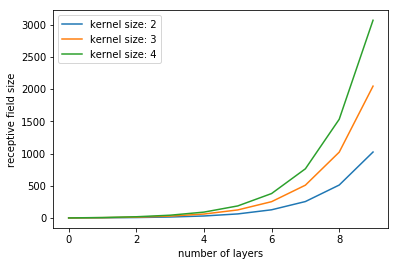

In [13]:
def _receptive_field_size_temporal_conv_net_(kernel_size, n_layers):
    return (1 + 2 * (kernel_size - 1) * (2 ** n_layers - 1))

for k in range(2, 5):
    plt.plot([_receptive_field_size_temporal_conv_net_(kernel_size=k, n_layers=n) for n in range(10)], label=f"kernel size: {k}")
plt.xlabel('number of layers')
plt.ylabel('receptive field size')
plt.legend()

In [14]:
def if_last(ls):
    for i, x in enumerate(ls):
        yield i + 1 == len(ls), x

def dense_layers(sizes):
    ls = tfk.Sequential([tfkl.Dense(size, activation=None if is_last else tf.nn.leaky_relu)  
                         for is_last, size in if_last(sizes)])
    
    return ls


class R_VAE(tf.keras.Model):
    def __init__(self, latent_dim, input_shape, batch_size):
        super(R_VAE, self).__init__()
        self.latent_dim = latent_dim
        self._input_shape = input_shape
        self._batch_size = batch_size
        self._layer_sizes = np.linspace(input_shape[0], 2 * latent_dim, 3)
        
        if len(input_shape) == 1:
            self.inference_net = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=input_shape),
                                                      dense_layers(self._layer_sizes)],
                                                     name='inference_net')

            self.generative_net = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                                                       tf.keras.layers.Dense(input_shape[0])],
                                                      name='generative_net')
            self.temporal_conv_net = None
        elif len(input_shape) == 2:
            self._layer_sizes = np.linspace(input_shape[-1], 2 * latent_dim, 3)
            self.inference_net = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=input_shape[-1]),
                                                      dense_layers(self._layer_sizes)],
                                                     name='inference_net')

            self.generative_net = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                                                       tf.keras.layers.Dense(input_shape[-1])],
                                                      name='generative_net')
            
            print("n channels", [input_shape[-1]] * 3)
            self.temporal_conv_net = TemporalConvNet(num_channels=[input_shape[-1]] * 3, name='temporal_conv_net')
        else:
            raise ValueError(f"Input shape is not good, got: {input_shape}")
    
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random_normal(shape=(self._batch_size, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
  
    def encode(self, x, training=False):
        if self.temporal_conv_net:
            # taking only the last entry
            x_tmp = tfkl.Lambda(lambda x: x[:, -1, :])(self.temporal_conv_net(x, training=training))
            mean, logvar = tf.split(self.inference_net(x_tmp), num_or_size_splits=2, axis=1)
        else:
            mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar
  
    def reparameterize(self, mean, logvar):
        eps = tf.random_normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
  
    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
  
        return logits

    def predict(self, x):
        mean, logvar = self.encode(x)
        z = model.reparameterize(mean, logvar)
        return model.decode(z, apply_sigmoid=True)

## Define the loss function and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, we optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

**Note**: we could also analytically compute the KL term, but here we incorporate all three terms in the Monte Carlo estimator for simplicity.

In [15]:
data_test.shape

(462, 30)

In [19]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
  
    if len(x.shape) == 2:
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    else:
        # Note, the model is trained to reconstruct only the last, most current time step (by taking the last entry in the timeseries)
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x[:, -1, :])
    #logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1]) # down to [batch, loss]
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

def compute_gradients(model, x): 
    with tf.GradientTape() as tape: 
        loss = compute_loss(model, x) 
        return tape.gradient(loss, model.trainable_variables), loss

optimizer = tf.train.AdamOptimizer(1e-4)
def apply_gradients(optimizer, gradients, variables, global_step=None):
    optimizer.apply_gradients(zip(gradients, variables), global_step=global_step)

In [20]:
epochs = 10
latent_dim = 16 

num_examples_to_generate = 16

tf.reset_default_graph()
test_losses = []
train_losses = []

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random_normal(shape=[num_examples_to_generate, latent_dim])
model = R_VAE(latent_dim, input_shape=data_train.shape[1:], batch_size=_BATCH_SIZE_)

In [21]:
# TODO add tensorboard stuff

def _compute_loss_for_data_(model, data):
    loss = tfe.metrics.Mean()
    for x in data:
        loss(compute_loss(model, x))
    elbo = -loss.result()
    
    return elbo

#print(f"will train for {epochs} epochs")
#for epoch in range(1, epochs + 1):
print(f"will train for ever...")
epoch = len(train_losses)
while True:
    start_time = time.time()
    for train_x in train_dataset:
        gradients, loss = compute_gradients(model, train_x)
        apply_gradients(optimizer, gradients, model.trainable_variables)
    end_time = time.time()

    test_losses += [_compute_loss_for_data_(model, test_dataset)]
    train_losses += [_compute_loss_for_data_(model, train_dataset)]

    if epoch % 10 == 0:
        print(f"Epoch: {epoch:0>3}, train test loss: {test_losses[-1]:0.3f}, took {end_time - start_time:0.3f} sec")
        
    epoch += 1

will train for ever...
Epoch: 000, train test loss: -24.861, took 0.131 sec
Epoch: 010, train test loss: -23.361, took 0.100 sec
Epoch: 020, train test loss: -22.926, took 0.100 sec
Epoch: 030, train test loss: -22.692, took 0.100 sec
Epoch: 040, train test loss: -22.323, took 0.107 sec
Epoch: 050, train test loss: -22.223, took 0.101 sec
Epoch: 060, train test loss: -22.043, took 0.100 sec
Epoch: 070, train test loss: -21.910, took 0.101 sec
Epoch: 080, train test loss: -21.747, took 0.100 sec
Epoch: 090, train test loss: -21.650, took 0.100 sec
Epoch: 100, train test loss: -21.610, took 0.101 sec
Epoch: 110, train test loss: -21.453, took 0.100 sec
Epoch: 120, train test loss: -21.430, took 0.101 sec
Epoch: 130, train test loss: -21.247, took 0.101 sec
Epoch: 140, train test loss: -21.211, took 0.101 sec
Epoch: 150, train test loss: -21.056, took 0.100 sec
Epoch: 160, train test loss: -21.019, took 0.100 sec
Epoch: 170, train test loss: -21.025, took 0.096 sec
Epoch: 180, train test 

Epoch: 1540, train test loss: -19.955, took 0.140 sec
Epoch: 1550, train test loss: -19.949, took 0.157 sec
Epoch: 1560, train test loss: -19.942, took 0.159 sec
Epoch: 1570, train test loss: -19.948, took 0.160 sec
Epoch: 1580, train test loss: -19.945, took 0.164 sec
Epoch: 1590, train test loss: -19.948, took 0.158 sec
Epoch: 1600, train test loss: -19.959, took 0.161 sec
Epoch: 1610, train test loss: -19.938, took 0.159 sec
Epoch: 1620, train test loss: -19.949, took 0.154 sec
Epoch: 1630, train test loss: -19.927, took 0.158 sec
Epoch: 1640, train test loss: -19.941, took 0.139 sec
Epoch: 1650, train test loss: -19.959, took 0.123 sec
Epoch: 1660, train test loss: -19.934, took 0.145 sec
Epoch: 1670, train test loss: -19.916, took 0.125 sec
Epoch: 1680, train test loss: -19.946, took 0.131 sec
Epoch: 1690, train test loss: -19.933, took 0.127 sec
Epoch: 1700, train test loss: -19.940, took 0.139 sec
Epoch: 1710, train test loss: -19.945, took 0.159 sec
Epoch: 1720, train test loss

KeyboardInterrupt: 

In [ ]:
len(train_losses)

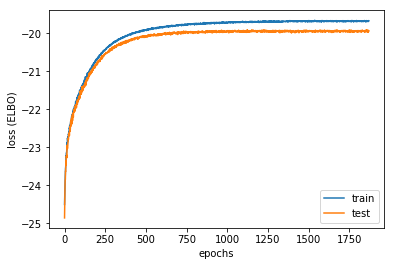

In [22]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('epochs')
plt.ylabel('loss (ELBO)')
plt.legend()

In [23]:
def _reverse_to_original_shape_(pos_data, input_shape=None):
    input_shape = (15, -1)
        
    return scaler.inverse_transform(pos_data).reshape(pos_data.shape[0], *(input_shape))

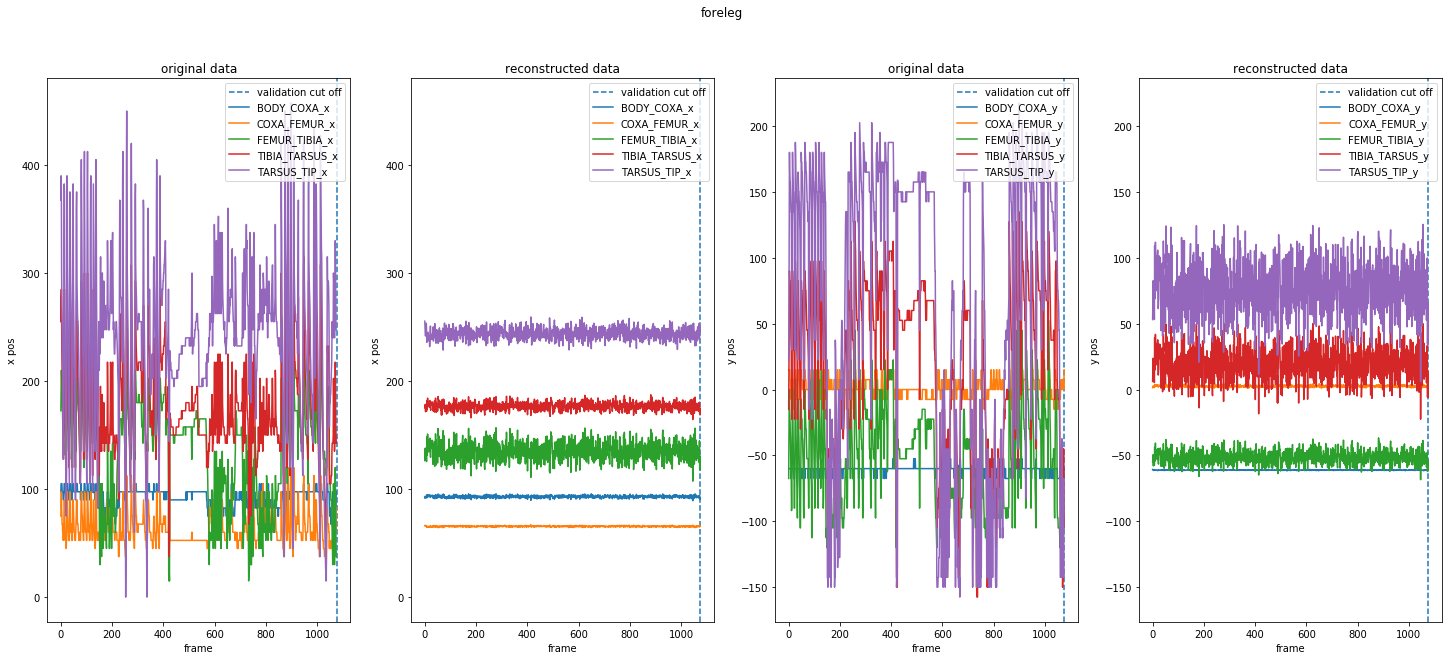

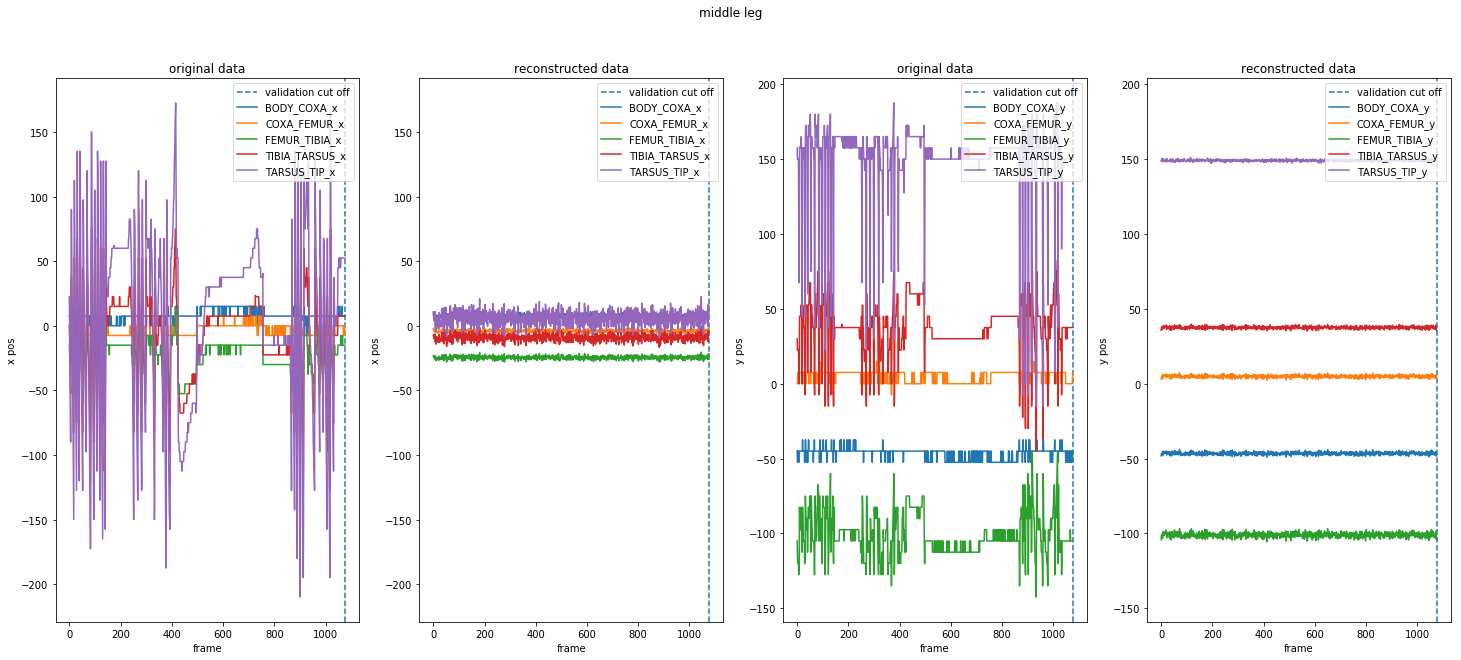

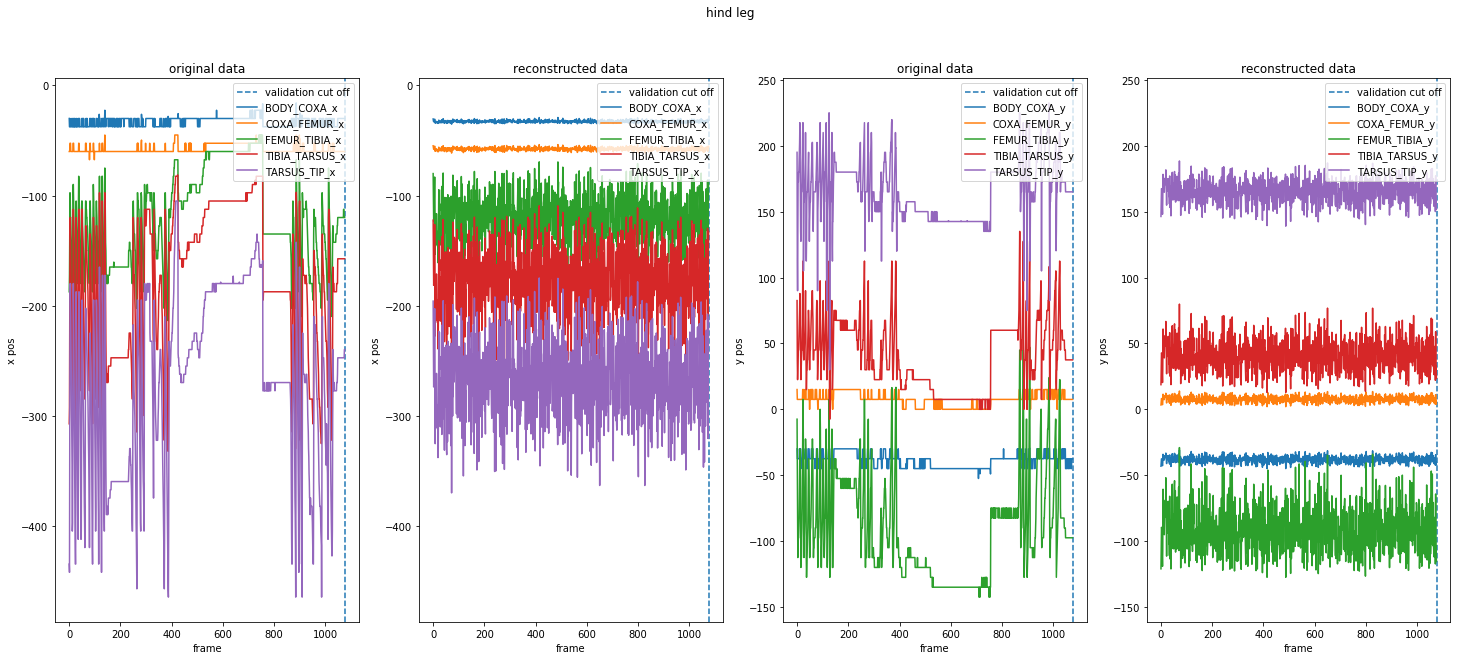

In [24]:
gen_pos_data = _reverse_to_original_shape_(np.vstack([model.sample().numpy() for _ in range(11)]))

plots.plot_comparing_joint_position_with_reconstructed(_reverse_to_original_shape_(data_train), gen_pos_data[:data_train.shape[0]], validation_cut_off=data_train.shape[0])

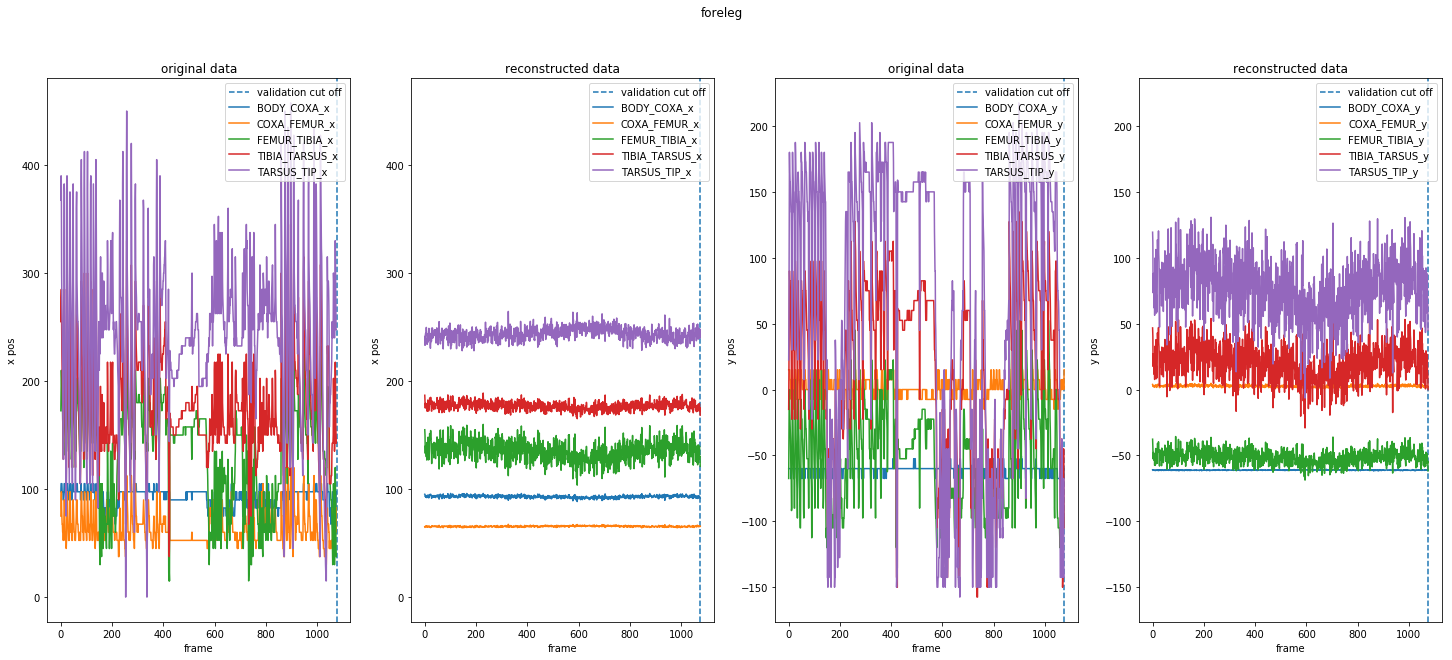

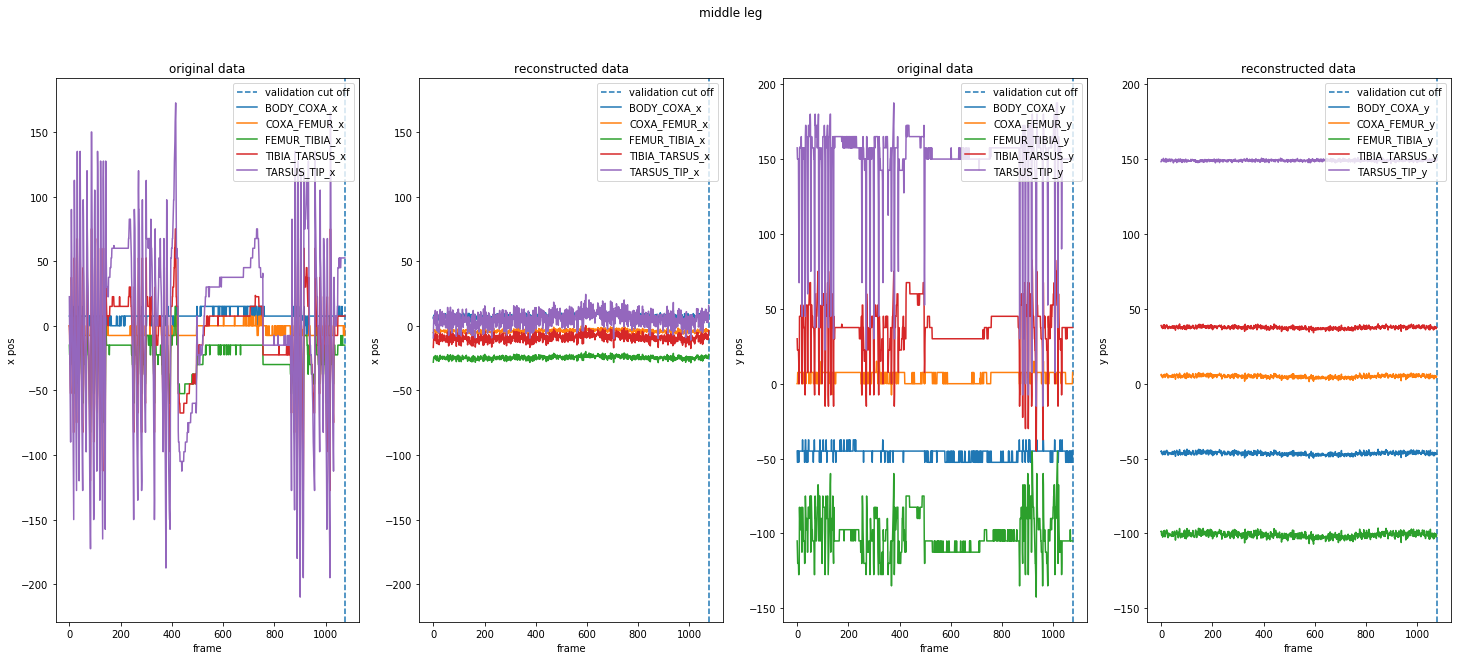

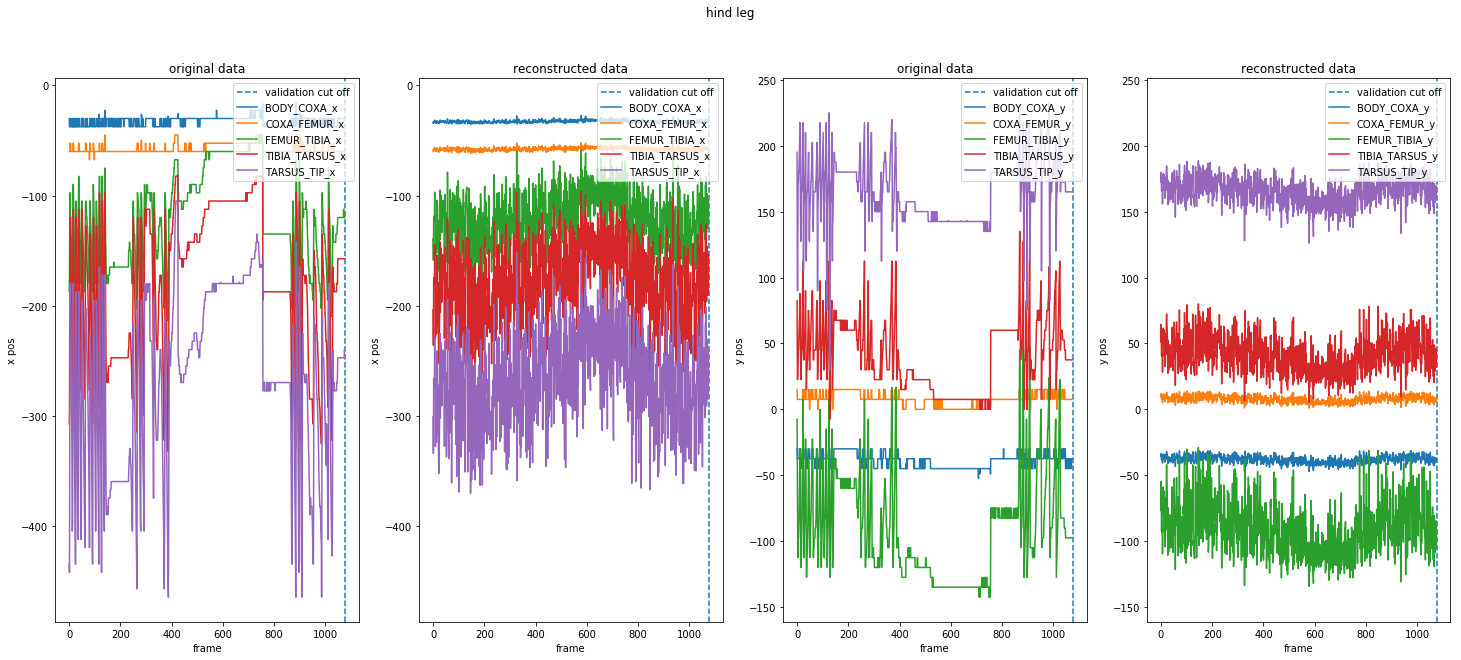

In [25]:
pred_train = model.predict(data_train).numpy()
pred_train_rev = _reverse_to_original_shape_(model.predict(data_train).numpy())

plots.plot_comparing_joint_position_with_reconstructed(_reverse_to_original_shape_(data_train), pred_train_rev, validation_cut_off=data_train.shape[0])

In [ ]:
stop
reload(plots)
if config.NB_DIMS == 3:
    if som_vae_config['time_series']:
        _time_series_idx_ = [t[-1] for t in to_time_series(range(len(joint_positions)))]
        timed_jp = joint_positions[_time_series_idx_]
    else:
        timed_jp = joint_positions
        
    f = plots.plot_reconstructed_angle_data(real_data=timed_jp,
                                            reconstructed_data=np.vstack((reconstructed_from_encoding_train, reconstructed_from_encoding_val)), 
                                            columns=angled_data_columns)
    p = f"../neural_clustering_data/figures/{som_vae_config['ex_name']}_angled_plot_.png"
    pathlib.Path(p).parent.mkdir(exist_ok=True)
    f.savefig(p)
else:
    if som_vae_config['time_series']:
        _time_series_idx_ = [t[-1] for t in to_time_series(range(len(joint_positions)))]
        timed_jp = joint_positions[_time_series_idx_]

        plots.plot_comparing_joint_position_with_reconstructed(timed_jp, 
                                                               np.vstack((reconstructed_from_encoding_train, reconstructed_from_encoding_val)), 
                                                               validation_cut_off=nb_of_data_points)
    else:
        plots.plot_comparing_joint_position_with_reconstructed(joint_positions, 
                                                               np.vstack((reconstructed_from_encoding_train, reconstructed_from_encoding_val)), 
                                                               validation_cut_off=nb_of_data_points)

        plots.plot_comparing_joint_position_with_reconstructed(joint_positions, 
                                                               np.vstack((reconstructed_from_embedding_train, reconstructed_from_embedding_val)), 
                                                               validation_cut_off=nb_of_data_points)

# Graveyard

In [ ]:
#class TemporalBlock(tf.keras.Model):
#    def __init__(self, dilation_rate, nb_filters, kernel_size, padding, dropout_rate=0.0): 
#        super(TemporalBlock, self).__init__()
#        # TODO check if this is correct
#        init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01)
#        assert padding in ['causal', 'same']
#
#        # block1
#        self.conv1  = tfkl.Conv1D(filters=nb_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding=padding, kernel_initializer=init)
#        self.batch1 = tfkl.BatchNormalization(axis=-1)
#        self.ac1    = tfkl.Activation('relu')
#        self.drop1  = tfkl.Dropout(rate=dropout_rate)
#        
#        # block2
#        self.conv2  = tfkl.Conv1D(filters=nb_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding=padding, kernel_initializer=init)
#        self.batch2 = tfkl.BatchNormalization(axis=-1)        
#        self.ac2    = tfkl.Activation('relu')
#        self.drop2  = tfkl.Dropout(rate=dropout_rate)
#
#        self.downsample = tfkl.Conv1D(filters=nb_filters, kernel_size=1, padding='same', kernel_initializer=init)
#        self.ac3    = tfkl.Activation('relu')
#
#
#    def call(self, x, training):
#        prev_x = x
#        x = self.conv1(x)
#        x = self.batch1(x)
#        x = self.ac1(x)
#        x = self.drop1(x) if training else x
#
#        x = self.conv2(x)
#        x = self.batch2(x)
#        x = self.ac2(x)
#        x = self.drop2(x) if training else x
#
#        if prev_x.shape[-1] != x.shape[-1]:    # match the dimention
#            prev_x = self.downsample(prev_x)
#        assert prev_x.shape == x.shape
#
#        return self.ac3(prev_x + x)            # skip connection
#
#
#
#class TemporalConvNet(tf.keras.Model):
#    def __init__(self, num_channels, kernel_size=2, dropout=0.2):
#        # num_channels is a list contains hidden sizes of Conv1D
#        super(TemporalConvNet, self).__init__()
#        assert isinstance(num_channels, list)
#
#        model = tf.keras.Sequential()
#
#        # The model contains "num_levels" TemporalBlock
#        num_levels = len(num_channels)
#        for i in range(num_levels):
#            dilation_rate = 2 ** i                  # exponential growth
#            model.add(TemporalBlock(dilation_rate=dilation_rate, nb_filters=num_channels[i], kernel_size=kernel_size, padding='causal', dropout_rate=dropout))
#        self.network = model
#
#    def call(self, x, training):
#        return self.network(x, training=training)

# V3
from typing import List, Tuple

import keras.backend as K
import keras.layers
from keras import optimizers
from keras.engine.topology import Layer
from keras.layers import Activation, Lambda
from keras.layers import Conv1D, SpatialDropout1D
from keras.layers import Convolution1D, Dense
from keras.models import Input, Model


def residual_block(x, dilation_rate, nb_filters, kernel_size, padding, dropout_rate=0):
    # type: (Layer, int, int, int, str, float) -> Tuple[Layer, Layer]
    """Defines the residual block for the WaveNet TCN

    Args:
        x: The previous layer in the model
        dilation_rate: The dilation power of 2 we are using for this residual block
        nb_filters: The number of convolutional filters to use in this block
        kernel_size: The size of the convolutional kernel
        padding: The padding used in the convolutional layers, 'same' or 'causal'.
        dropout_rate: Float between 0 and 1. Fraction of the input units to drop.

    Returns:
        A tuple where the first element is the residual model layer, and the second
        is the skip connection.
    """
    prev_x = x
    for k in range(2):
        x = Conv1D(filters=nb_filters,
                   kernel_size=kernel_size,
                   dilation_rate=dilation_rate,
                   padding=padding)(x)
        # x = BatchNormalization()(x)  # TODO should be WeightNorm here.
        x = Activation('relu')(x)
        x = SpatialDropout1D(rate=dropout_rate)(x)

    # 1x1 conv to match the shapes (channel dimension).
    prev_x = Conv1D(nb_filters, 1, padding='same')(prev_x)
    res_x = keras.layers.add([prev_x, x])
    return res_x, x


def process_dilations(dilations):
    def is_power_of_two(num):
        return num != 0 and ((num & (num - 1)) == 0)

    if all([is_power_of_two(i) for i in dilations]):
        return dilations

    else:
        new_dilations = [2 ** i for i in dilations]
        # print(f'Updated dilations from {dilations} to {new_dilations} because of backwards compatibility.')
        return new_dilations


class TCN(tf.layers.Layer):
    """Creates a TCN layer.

        Input shape:
            A tensor of shape (batch_size, timesteps, input_dim).

        Args:
            nb_filters: The number of filters to use in the convolutional layers.
            kernel_size: The size of the kernel to use in each convolutional layer.
            dilations: The list of the dilations. Example is: [1, 2, 4, 8, 16, 32, 64].
            nb_stacks : The number of stacks of residual blocks to use.
            padding: The padding to use in the convolutional layers, 'causal' or 'same'.
            use_skip_connections: Boolean. If we want to add skip connections from input to each residual block.
            return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
            dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
            name: Name of the model. Useful when having multiple TCN.

        Returns:
            A TCN layer.
        """

    def __init__(self,
                 nb_filters=64,
                 kernel_size=2,
                 nb_stacks=1,
                 dilations=[1, 2, 4, 8, 16, 32],
                 padding='causal',
                 use_skip_connections=True,
                 dropout_rate=0.0,
                 return_sequences=False,
                 name='tcn'):
        self.name = name
        self.return_sequences = return_sequences
        self.dropout_rate = dropout_rate
        self.use_skip_connections = use_skip_connections
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.nb_filters = nb_filters
        self.padding = padding

        if padding != 'causal' and padding != 'same':
            raise ValueError("Only 'causal' or 'same' padding are compatible for this layer.")


    def __call__(self, inputs):
        x = inputs
        # 1D FCN.
        x = Convolution1D(self.nb_filters, 1, padding=self.padding)(x)
        skip_connections = []
        for s in range(self.nb_stacks):
            for d in self.dilations:
                x, skip_out = residual_block(x,
                                             dilation_rate=d,
                                             nb_filters=self.nb_filters,
                                             kernel_size=self.kernel_size,
                                             padding=self.padding,
                                             dropout_rate=self.dropout_rate)
                skip_connections.append(skip_out)
        if self.use_skip_connections:
            x = keras.layers.add(skip_connections)
        if not self.return_sequences:
            x = Lambda(lambda tt: tt[:, -1, :])(x)
        return x